<a href="https://colab.research.google.com/github/greyhound101/IEEE-CIS-Fraud/blob/master/simple_model_focal_loss_with_uid_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading libraries

In [ ]:
import pandas as pd
from tensorflow.keras.layers import *
import tensorflow as tf
import random, os, sys
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
import tensorflow as tf
from google.colab import drive
import os
from sklearn.preprocessing import LabelEncoder
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from keras.layers import *
from keras.optimizers import *
from keras.models import *
from keras import backend as K
from tensorflow.keras.models import *
import tensorflow.keras.backend as K
from tensorflow.keras.layers import *
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
import gc

In [ ]:

os.environ['KAGGLE_USERNAME'] = "tapaskd123" # username from the json file
os.environ['KAGGLE_KEY'] = "aba8dc1f085221111d925003fe5a88ed" # key from the json file
!kaggle competitions download -c ieee-fraud-detection

train_transaction.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_identity.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train_identity.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_transaction.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


loading drive

In [ ]:
drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive
Mounted at /content/gdrive


Loading dataframes

In [ ]:
trn=pd.read_csv('/content/gdrive/My Drive/fraud/train_id.csv',index_col=[0])
tst=pd.read_csv('/content/gdrive/My Drive/fraud/test_id.csv',index_col=[0])
trn.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,C9_std_isna,C10_std_isna,C11_std_isna,C12_std_isna,C13_std_isna,C14_std_isna,D1_mean_isna,D1_std_isna,D2_mean_isna,D2_std_isna,D3_mean_isna,D3_std_isna,D4_mean_isna,D4_std_isna,D5_mean_isna,D5_std_isna,D6_mean_isna,D6_std_isna,D7_mean_isna,D7_std_isna,D8_mean_isna,D8_std_isna,D9_mean_isna,D9_std_isna,D10_mean_isna,D10_std_isna,D11_mean_isna,D11_std_isna,D12_mean_isna,D12_std_isna,D13_mean_isna,D13_std_isna,D14_mean_isna,D14_std_isna,D15_mean_isna,D15_std_isna,V1_mean_isna,V1_std_isna,isFraud,id
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,1,1,1,1,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1,1,1,0,1,0,1,0,Wnan315.013926-13.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,0,1,1,1,0,Wgmail.com325.027551.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,Woutlook.com330.046631.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,0,0,1,1,0,Wyahoo.com476.018132-111.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,Hgmail.com420.044971.0


Reduce memory useage

In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df
trn=reduce_mem_usage(trn)
tst=reduce_mem_usage(tst)

Memory usage of dataframe is 2793.39 MB
Memory usage after optimization is: 678.37 MB
Decreased by 75.7%
Memory usage of dataframe is 2392.90 MB
Memory usage after optimization is: 580.09 MB
Decreased by 75.8%


In [ ]:
trn=trn.replace([np.inf,-np.inf],np.nan)
tst=tst.replace([np.inf,-np.inf],np.nan)
a=trn.isna().sum()
ls=a[a>0].index
for col in ls:
  trn[col]=trn[col].fillna(trn[col].mean())
  tst[col]=tst[col].fillna(tst[col].mean())
a=trn.isna().sum()
ls=a[a>0].index
for col in ls:
  trn[col]=trn[col].fillna(0)
  tst[col]=tst[col].fillna(0)
a=tst.isna().sum()
ls=a[a>0].index
for col in ls:
  trn[col]=trn[col].fillna(trn[col].mean())
  tst[col]=tst[col].fillna(tst[col].mean())
a=tst.isna().sum()
ls=a[a>0].index
for col in ls:
  trn[col]=trn[col].fillna(0)
  tst[col]=tst[col].fillna(0)

Making the callbacks and loading model

In [ ]:
dk={}
class RocCallback(Callback):
    def __init__(self,validation_data,epochs):
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]
        self.ep=0
        self.epochs=epochs
        self.val=0
        self.wts=[]

    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        self.ep+=1
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        if roc_val>self.val:
          self.val=roc_val
          self.epoch=10
          self.wts=self.model.get_weights()
        else:
          self.epoch-=1
        if self.epoch==0:
          self.model.set_weights(self.wts)
          self.model.stop_training = True
        print('roc-auc_val: %s' % str(round(roc_val,4)))

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return
def load_model(dim):
  K.clear_session()


  uid=Input((1,))
  inp=Input((873,))
  emb=Embedding(input_dim=dim,output_dim=4)(uid)
  emb=Flatten()(emb)
  x=Dense(256,activation='relu')(inp)
  x=BatchNormalization()(x)
  x=Dropout(0.3)(x)
  x=Dense(256,activation='relu')(inp)
  x=BatchNormalization()(x)
  x=Dropout(0.3)(x)
  x=Dense(256,activation='relu')(x)
  x=Dropout(0.3)(x)
  emb=Flatten()(emb)
  x=Concatenate()([emb,x])
  x=Dense(1,activation='sigmoid')(x)
  mod=Model(inputs=[inp,uid],outputs=x)
  return mod

def custom_gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))

Adding all datasets

In [ ]:
trn_s=trn.shape[0]
df=pd.concat([trn,tst],0).reset_index(drop=True)
del([trn,tst])
gc.collect()


autoenc=pd.read_csv('/content/gdrive/My Drive/fraud/without_id.csv',index_col=[0])
autoenc=reduce_mem_usage(autoenc)

autoenc.columns=[i for i in range(444,444+autoenc.shape[1])]


df=pd.concat([df,autoenc],1)
del([autoenc])
gc.collect()

trn=df.loc[:trn_s-1]
tst=df.loc[trn_s:].reset_index(drop=True)
del([df])
gc.collect()

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Memory usage of dataframe is 2151.40 MB
Memory usage after optimization is: 544.13 MB
Decreased by 74.7%


0

In [ ]:
categorical=[str(i) for i in range(444)]
trn[categorical]=trn[categorical].astype('uint8')
tst[categorical]=tst[categorical].astype('uint8')

In [ ]:
def fl():
    def focal_loss(y_true, y_pred):
        gamma=4
        alpha=0.9
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        pt_1 = K.clip(pt_1, 1e-3, .999)
        pt_0 = K.clip(pt_0, 1e-3, .999)

        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss


0it [00:00, ?it/s]

Epoch 1/50
231/231 [==============================] - 6s 20ms/step - loss: 42.8738 - val_loss: 20.5314
roc-auc_val: 0.8891
Epoch 2/50
231/231 [==============================] - 4s 15ms/step - loss: 22.4375 - val_loss: 19.6160
roc-auc_val: 0.8969
Epoch 3/50
231/231 [==============================] - 4s 16ms/step - loss: 17.0746 - val_loss: 17.5284
roc-auc_val: 0.9136
Epoch 4/50
231/231 [==============================] - 4s 15ms/step - loss: 13.2221 - val_loss: 17.5899
roc-auc_val: 0.9159
Epoch 5/50
231/231 [==============================] - 4s 17ms/step - loss: 10.0501 - val_loss: 17.0745
roc-auc_val: 0.9218
Epoch 6/50
231/231 [==============================] - 4s 17ms/step - loss: 8.0465 - val_loss: 16.7423
roc-auc_val: 0.9252
Epoch 7/50
231/231 [==============================] - 4s 17ms/step - loss: 6.1294 - val_loss: 16.6238
roc-auc_val: 0.928
Epoch 8/50
231/231 [==============================] - 4s 16ms/step - loss: 5.0042 - val_loss: 17.3118
roc-auc_val: 0.9224
Epoch 9/50
231/231 [

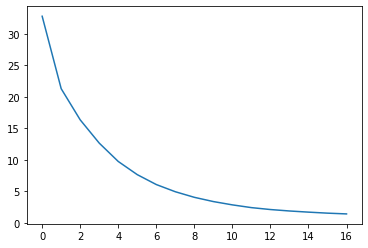

Epoch 1/2
58/58 [==============================] - 1s 14ms/step - loss: 14.5749
Epoch 2/2
58/58 [==============================] - 1s 14ms/step - loss: 12.4524



1it [03:31, 211.32s/it]

Epoch 1/50
231/231 [==============================] - 7s 22ms/step - loss: 37.3560 - val_loss: 24.5274
roc-auc_val: 0.898
Epoch 2/50
231/231 [==============================] - 4s 16ms/step - loss: 20.7154 - val_loss: 22.1801
roc-auc_val: 0.9218
Epoch 3/50
231/231 [==============================] - 4s 16ms/step - loss: 16.0789 - val_loss: 19.6920
roc-auc_val: 0.9366
Epoch 4/50
231/231 [==============================] - 4s 16ms/step - loss: 12.7502 - val_loss: 18.7397
roc-auc_val: 0.941
Epoch 5/50
231/231 [==============================] - 4s 17ms/step - loss: 9.4710 - val_loss: 19.1447
roc-auc_val: 0.9362
Epoch 6/50
231/231 [==============================] - 4s 17ms/step - loss: 7.6061 - val_loss: 17.5035
roc-auc_val: 0.9485
Epoch 7/50
231/231 [==============================] - 4s 17ms/step - loss: 5.9805 - val_loss: 17.5269
roc-auc_val: 0.9484
Epoch 8/50
231/231 [==============================] - 4s 16ms/step - loss: 4.7498 - val_loss: 17.6513
roc-auc_val: 0.9496
Epoch 9/50
231/231 [==

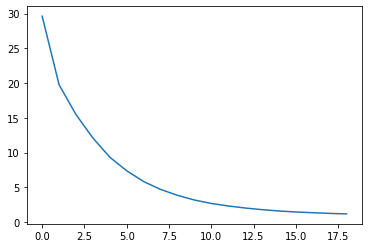

Epoch 1/2
58/58 [==============================] - 1s 14ms/step - loss: 16.0121
Epoch 2/2
58/58 [==============================] - 1s 13ms/step - loss: 13.2927



2it [07:20, 216.71s/it]

Epoch 1/50
231/231 [==============================] - 7s 23ms/step - loss: 41.2302 - val_loss: 23.6703
roc-auc_val: 0.896
Epoch 2/50
231/231 [==============================] - 4s 16ms/step - loss: 21.5081 - val_loss: 21.6898
roc-auc_val: 0.9146
Epoch 3/50
231/231 [==============================] - 4s 16ms/step - loss: 16.9471 - val_loss: 19.9929
roc-auc_val: 0.9275
Epoch 4/50
231/231 [==============================] - 4s 17ms/step - loss: 12.9575 - val_loss: 18.4784
roc-auc_val: 0.9393
Epoch 5/50
231/231 [==============================] - 4s 17ms/step - loss: 10.1410 - val_loss: 17.4182
roc-auc_val: 0.9459
Epoch 6/50
231/231 [==============================] - 4s 17ms/step - loss: 7.8292 - val_loss: 17.7630
roc-auc_val: 0.9442
Epoch 7/50
231/231 [==============================] - 4s 17ms/step - loss: 6.3456 - val_loss: 17.2232
roc-auc_val: 0.948
Epoch 8/50
231/231 [==============================] - 4s 16ms/step - loss: 4.8954 - val_loss: 17.6057
roc-auc_val: 0.947
Epoch 9/50
231/231 [==

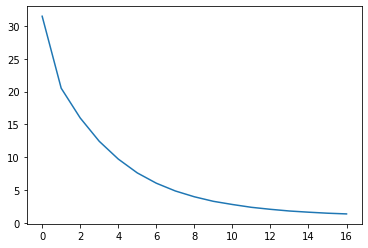

Epoch 1/2
58/58 [==============================] - 1s 13ms/step - loss: 16.0547
Epoch 2/2
58/58 [==============================] - 1s 13ms/step - loss: 13.4791



3it [10:49, 214.36s/it]

Epoch 1/50
231/231 [==============================] - 7s 25ms/step - loss: 40.9808 - val_loss: 22.5578
roc-auc_val: 0.9114
Epoch 2/50
231/231 [==============================] - 4s 16ms/step - loss: 21.8394 - val_loss: 19.8235
roc-auc_val: 0.9344
Epoch 3/50
231/231 [==============================] - 4s 17ms/step - loss: 16.8923 - val_loss: 18.2782
roc-auc_val: 0.9465
Epoch 4/50
231/231 [==============================] - 4s 17ms/step - loss: 13.0230 - val_loss: 17.0693
roc-auc_val: 0.9547
Epoch 5/50
231/231 [==============================] - 4s 17ms/step - loss: 10.0990 - val_loss: 16.0073
roc-auc_val: 0.9596
Epoch 6/50
231/231 [==============================] - 4s 17ms/step - loss: 7.9265 - val_loss: 15.5593
roc-auc_val: 0.9614
Epoch 7/50
231/231 [==============================] - 4s 16ms/step - loss: 6.1361 - val_loss: 16.2682
roc-auc_val: 0.9612
Epoch 8/50
231/231 [==============================] - 4s 16ms/step - loss: 4.9728 - val_loss: 15.1954
roc-auc_val: 0.9633
Epoch 9/50
231/231 

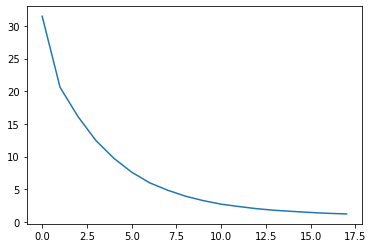

Epoch 1/2
58/58 [==============================] - 1s 14ms/step - loss: 14.9240
Epoch 2/2
58/58 [==============================] - 1s 13ms/step - loss: 12.8836



4it [14:35, 217.77s/it]

Epoch 1/50
231/231 [==============================] - 8s 26ms/step - loss: 46.6081 - val_loss: 23.5846
roc-auc_val: 0.8879
Epoch 2/50
231/231 [==============================] - 4s 17ms/step - loss: 22.7370 - val_loss: 22.1214
roc-auc_val: 0.9054
Epoch 3/50
231/231 [==============================] - 4s 17ms/step - loss: 17.3844 - val_loss: 20.3380
roc-auc_val: 0.9194
Epoch 4/50
231/231 [==============================] - 4s 17ms/step - loss: 13.1737 - val_loss: 19.2803
roc-auc_val: 0.9287
Epoch 5/50
231/231 [==============================] - 4s 16ms/step - loss: 10.0991 - val_loss: 18.6214
roc-auc_val: 0.9334
Epoch 6/50
231/231 [==============================] - 4s 16ms/step - loss: 7.9977 - val_loss: 18.5668
roc-auc_val: 0.9331
Epoch 7/50
231/231 [==============================] - 4s 16ms/step - loss: 6.3991 - val_loss: 17.7062
roc-auc_val: 0.9402
Epoch 8/50
231/231 [==============================] - 4s 16ms/step - loss: 5.0497 - val_loss: 17.7406
roc-auc_val: 0.94
Epoch 9/50
231/231 [=

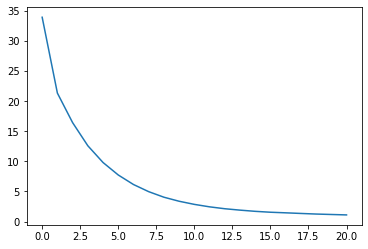

Epoch 1/2
58/58 [==============================] - 1s 14ms/step - loss: 16.6923
Epoch 2/2
58/58 [==============================] - 1s 14ms/step - loss: 14.3145



5it [18:49, 225.87s/it]


In [ ]:
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
splits=KFold(n_splits=5)
gc.collect()
pre=np.zeros((506691,1))
# tst=tst.drop(['isFraud'],1)
for en,(train_index,test_index) in enumerate(tqdm(splits.split(trn,trn['isFraud']))):
  X_train, X_test = trn.loc[train_index], trn.loc[test_index]
  y_train, y_test = X_train['isFraud'], X_test['isFraud']
  ids={}
  for en,id in enumerate(X_train['id'].unique()):
    ids[id]=en+2
  X_train['id']=X_train['id'].map(lambda x: ids.get(x,1))
  X_test['id']=X_test['id'].map(lambda x: ids.get(x,1))
  dim=X_train['id'].nunique()+2
  gc.collect()
  trn_id,tst_id=X_train['id'],X_test['id']
  X_train=X_train.drop(['isFraud','id'],1)
  X_test=X_test.drop(['isFraud','id'],1)
  mod=load_model(dim)
  roc = RocCallback(validation_data=([X_test,tst_id], y_test),epochs=10)
  mod.compile(optimizer=Nadam(),loss=fl())
  es=EarlyStopping(monitor='acu_val',min_delta=0.0001,mode='min',restore_best_weights=True,patience=10)

  hist = mod.fit([X_train,trn_id],y_train,validation_data=([X_test,tst_id],y_test),batch_size=2048,epochs=50,callbacks=[roc])
  

  plt.plot(hist.history['loss'])
  plt.savefig('/content/gdrive/My Drive/fraud/focal_loss_'+str(en)+'.png')
  plt.show()
  del[(X_train,y_train)]
  gc.collect()

  mod.fit([X_test,tst_id],y_test,epochs=2,batch_size=2048)
  pre+=mod.predict([tst.drop(['id'],1),tst['id'].map(lambda x: ids.get(x,1))])/5
  
  del([X_test,y_test,mod])
  gc.collect()

In [ ]:
sub=pd.read_csv('sample_submission.csv.zip')
sub['isFraud']=pre
sub=sub.set_index('TransactionID')
sub.head()

,isFraud
TransactionID,
3663549,0.035459
3663550,0.050117
3663551,0.193073
3663552,0.140387
3663553,0.121105


In [ ]:
sub.to_csv('sub.csv')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


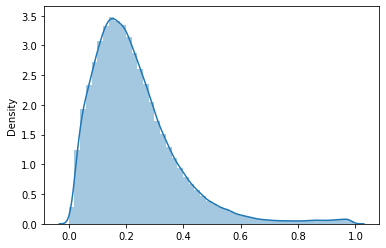

In [ ]:
import seaborn as sns
sns.distplot(pre)